In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import scipy as sp
from scipy.sparse import csr_matrix

In [5]:
def basis_set_generator(tot_sites, N_particles): # Checked OK
    basis = []

    for comb in combinations(range(tot_sites), N_particles):
        state = [0] * tot_sites
        for idx in comb:
            state[idx] = 1
        basis.append(state)
    
    return np.array(basis)


def state_idx_mapping(basis_set): # Checked OK
    return {tuple(state) : i for i, state in enumerate(basis_set)}


def creation_operator(state, i): # Checked OK
    if state[i] == 1:
        return 0, None
    
    res_state = state.copy()
    res_state[i] = 1

    sign = 1
    for j in range(i):
        if res_state[j] == 1:
            sign *= -1
    
    return sign, res_state


def annihilation_operator(state, i): # Checked OK
    if state[i] == 0:
        return 0, None
    
    res_state = state.copy()
    res_state[i] = 0

    sign = 1
    for j in range(i):
        if res_state[j] == 1:
            sign *= -1
    
    return sign, res_state


def hopping_operator(state, initial_position, target_position): # Checked OK
    sign_1, state_1 = annihilation_operator(state, initial_position)

    # if sign_1 == 0:
    #     return 0, None

    sign_2, state_2 = creation_operator(state_1, target_position)

    return sign_1 * sign_2, state_2


def hamiltonian_matrix_generator(basis_set, tot_sites, v, w, V1, V2): # Checked OK
    dim = len(basis_set)
    hamiltonian = np.zeros((dim, dim), dtype=np.float64)

    state_idx_dict = state_idx_mapping(basis_set)

    for i, state in enumerate(basis_set):
        for j in range(tot_sites):
            if state[j] == 0:
                continue

            if j + 1 < tot_sites:
                if state[j + 1] == 0:
                    initial_position = j
                    target_position = j + 1
                    # print(initial_position, target_position)
                    sign, res_state = hopping_operator(state, initial_position, target_position)
                    res_state_idx = state_idx_dict[tuple(res_state)]

                    if j % 2 == 0:
                        hamiltonian[res_state_idx, i] += v * sign
                    else:
                        hamiltonian[res_state_idx, i] += w * sign
                
                elif state[j + 1] == 1:
                    if j % 2 == 0:
                        hamiltonian[i, i] += V1
                    else:
                        hamiltonian[i, i] += V2

            if j - 1 >= 0:
                if state[j - 1] == 0:
                    initial_position = j
                    target_position = j - 1
                    sign, res_state = hopping_operator(state, initial_position, target_position)
                    res_state_idx = state_idx_dict[tuple(res_state)]

                    if j % 2 == 0:
                        hamiltonian[res_state_idx, i] += w * sign
                    else:
                        hamiltonian[res_state_idx, i] += v * sign
                
                elif state[j - 1] == 1:
                    if j % 2 == 0:
                        hamiltonian[i, i] += V2
                    else:
                        hamiltonian[i, i] += V1
    
    return hamiltonian


def normalize(vec):
  norm = np.linalg.norm(vec)
  if norm == 0:
    return vec
  return vec / norm


Time taken: 0:00:17.762914
[462, 461]
924


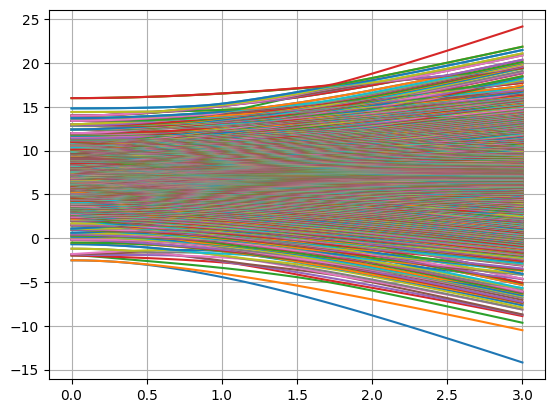

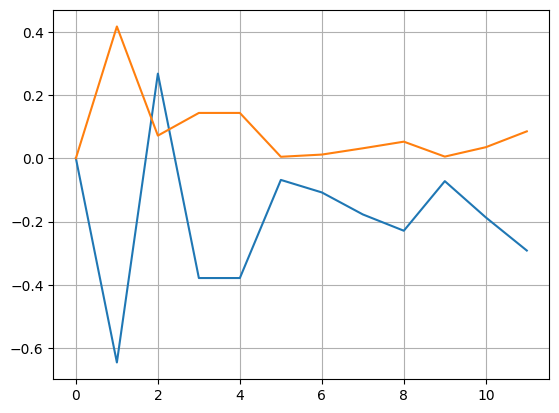

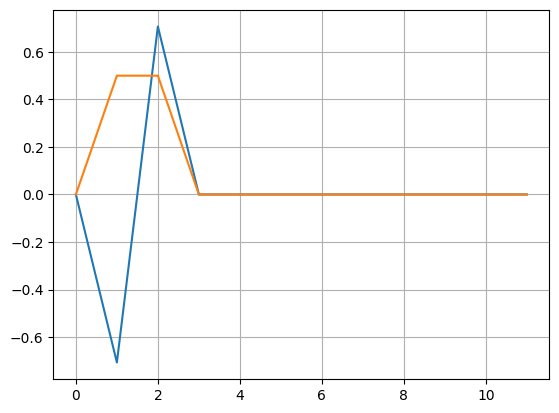

In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools as itr
import h5py
import os
from datetime import datetime
from functions import *


v_step_no = 101
v_0 = 0
v_end = 3
v_arr = np.linspace(v_0, v_end, v_step_no)
v_arr = np.around(v_arr, decimals=3)
w = 1
N = 6
tot_sites = 2 * N
N_e = N
topo_state_no = 2
V1 = 1
V2 = 2

start_time = datetime.now()



all_e_val_arr = []
topo_state_pos_sp_arr = np.zeros((v_step_no, topo_state_no, tot_sites))

for k, v in enumerate(v_arr):
    topo_state_arr = []
    topo_state_arr_idx_arr = []

    basis_set = basis_set_generator(tot_sites, N_e)
    hamiltonian = hamiltonian_matrix_generator(basis_set, tot_sites, v, w, V1, V2)

    dim = len(hamiltonian)

    e_val_arr, e_vec_arr = np.linalg.eigh(hamiltonian)

    all_e_val_arr.append(e_val_arr)

    # e_val_arr_abs = np.abs(e_val_arr)

    # e_val_arr_abs_sorted = np.sort(e_val_arr_abs)

    # for i in range(topo_state_no):
    #     topo_state_arr_idx_arr.append((e_val_arr_abs == e_val_arr_abs_sorted[i]).argmax())
    for i in range(topo_state_no//2):
        topo_state_arr_idx_arr.append((dim // 2) + i)
        topo_state_arr_idx_arr.append((dim // 2) - i - 1)

    for i in topo_state_arr_idx_arr:
        topo_state_arr.append(e_vec_arr[:, i])
    
    for i, state in enumerate(topo_state_arr):
        for j, element in enumerate(state):
            topo_state_pos_sp_arr[k][i] += element * basis_set[j]
        topo_state_pos_sp_arr[k][i] = normalize(topo_state_pos_sp_arr[k][i])

all_e_val_arr = np.array(all_e_val_arr)

end_time = datetime.now()
time_taken = end_time - start_time
print(f"Time taken: {time_taken}")
print(topo_state_arr_idx_arr)
print(dim)


for i, e_v_arr in enumerate(all_e_val_arr.transpose()):
    plt.plot(v_arr, e_v_arr)
# plt.legend()
plt.grid()
plt.show()

sites_arr = np.arange(tot_sites)
for state in topo_state_pos_sp_arr[0]:
    plt.plot(sites_arr, state)
    plt.plot(sites_arr, state**2)
    # plt.legend()
    plt.grid()
    plt.show()

In [8]:
N_sites = 2
tot_sites = N_sites * 2
N_particles = N_sites
v = 1
w = 2
V1 = 1
V2 = 2

basis_set = basis_set_generator(tot_sites, N_particles)
print(basis_set)
# state_idx_dict = state_idx_mapping(basis_set)
# print(state_idx_dict)
hamiltonian = hamiltonian_matrix_generator(basis_set, tot_sites, v, w, V1, V2)
print(hamiltonian)
print(sp.linalg.ishermitian(hamiltonian))

[[1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 1 1]]
[[2. 2. 0. 0. 0. 0.]
 [2. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 4. 1. 0.]
 [0. 0. 1. 1. 0. 2.]
 [0. 0. 0. 0. 2. 2.]]
True


In [9]:
e_val_arr, e_vec_arr = np.linalg.eigh(hamiltonian)
e_vec_arr = e_vec_arr.transpose()
print(e_val_arr)
print(np.shape(e_vec_arr))

wf_ps = np.zeros((len(e_vec_arr), tot_sites))

for i, state in enumerate(e_vec_arr):
    for j, weight in enumerate(state):
        wf_ps[i] += weight * basis_set[j]

        wf_ps[i] = normalize(wf_ps[i])

print(wf_ps)

[-2.19058797 -1.23606798  0.52471939  2.95451999  3.23606798  4.71134859]
(6, 6)
[[-0.91023199 -0.3594268   0.20332284  0.03082072]
 [-0.06118098 -0.73523311  0.67504679  0.00099467]
 [ 0.27239687 -0.61941217 -0.28784227  0.67769856]
 [-0.64605531 -0.18397041 -0.17779049 -0.71913696]
 [ 0.6290301   0.12131025 -0.22609592 -0.73381577]
 [ 0.28686413  0.66125165  0.54995349  0.42190802]]


In [10]:
topo_st_idx = []
tol = 10**(0)
for i in range(len(e_val_arr)):
    if np.abs(e_val_arr[i]) < tol:
        topo_st_idx.append(i)
print(topo_st_idx)

[2]


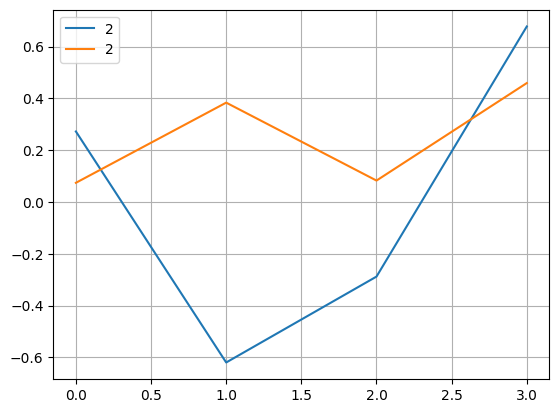

In [11]:
sites_arr = np.arange(tot_sites)
for i in topo_st_idx:
    plt.plot(sites_arr, wf_ps[i], label=f'{i}')
    plt.plot(sites_arr, wf_ps[i]**2, label=f'{i}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for state in basis_set:
    for i in range(tot_sites):
        # initial_site = i
        # target_site_right = i + 1
        # target_site_left = i - 1
        
        if i + 1 <= tot_sites - 1:
            print(f"{state} ---- {i}, {i + 1}: {hopping_operator(state, i, i + 1)}")
        if i - 1 >= 0:
            print(f"{state} ---- {i}, {i - 1}: {hopping_operator(state, i, i - 1)}")


# state = basis_set[1]
# for i in range(tot_sites):
#     print(f"{state} ---- {i}, {i + 1}: {hopping_operator(state, i, i + 1)}")
#     print(f"{state} ---- {i}, {i - 1}: {hopping_operator(state, i, i - 1)}")

In [6]:
print(creation_operator(basis_set[0], 1))
for state in basis_set:
    for j in range(tot_sites):
        # print(f"{state} --- {j} : {creation_operator(state, j)}") 
        print(f"{state} --- {j} : {annihilation_operator(state, j)}") 

(0, None)
[1 1 0 0] --- 0 : (1, array([0, 1, 0, 0]))
[1 1 0 0] --- 1 : (-1, array([1, 0, 0, 0]))
[1 1 0 0] --- 2 : (0, None)
[1 1 0 0] --- 3 : (0, None)
[1 0 1 0] --- 0 : (1, array([0, 0, 1, 0]))
[1 0 1 0] --- 1 : (0, None)
[1 0 1 0] --- 2 : (-1, array([1, 0, 0, 0]))
[1 0 1 0] --- 3 : (0, None)
[1 0 0 1] --- 0 : (1, array([0, 0, 0, 1]))
[1 0 0 1] --- 1 : (0, None)
[1 0 0 1] --- 2 : (0, None)
[1 0 0 1] --- 3 : (-1, array([1, 0, 0, 0]))
[0 1 1 0] --- 0 : (0, None)
[0 1 1 0] --- 1 : (1, array([0, 0, 1, 0]))
[0 1 1 0] --- 2 : (-1, array([0, 1, 0, 0]))
[0 1 1 0] --- 3 : (0, None)
[0 1 0 1] --- 0 : (0, None)
[0 1 0 1] --- 1 : (1, array([0, 0, 0, 1]))
[0 1 0 1] --- 2 : (0, None)
[0 1 0 1] --- 3 : (-1, array([0, 1, 0, 0]))
[0 0 1 1] --- 0 : (0, None)
[0 0 1 1] --- 1 : (0, None)
[0 0 1 1] --- 2 : (1, array([0, 0, 0, 1]))
[0 0 1 1] --- 3 : (-1, array([0, 0, 1, 0]))


In [21]:
print(np.where(basis_set == basis_set[1]))
basis = tuple(basis_set[1].copy())
print(tuple(basis_set[1]) == basis)

(array([0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 5, 5]), array([0, 3, 0, 1, 2, 3, 0, 1, 2, 3, 1, 2]))
True
